In [3]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/learn_observe_KKL.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

In [1]:
import sys ; sys.path.append('../')
import torch.optim as optim
import seaborn as sb
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learner import Learner

sb.set_style('whitegrid')

In [10]:
# Generate the data
system = RevDuffing()
data = system.generate_mesh([-1., 1.], 50000)
data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

# Create the observer (autoencoder design)
observer = LuenbergerObserver(dim_x=2, dim_y=1, method="Autoencoder")
observer.set_dynamics(system)

# Train using pytorch-lightning and the learner class
trainer_options={'max_epochs': 30}
optimizer_options = {'weight_decay': 0.1}
scheduler_options = {'mode': 'min', 'factor': 0.5, 'patience': 3,
                     'threshold': 5e-2, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=1e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner = Learner(observer, training_data=data, validation_data=val_data,
                  method='Autoencoder', batch_size=10, lr=5e-4,
                  optimizer=optim.Adam, optimizer_options=optimizer_options,
                  scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                  scheduler_options=scheduler_options)
logger = TensorBoardLogger(save_dir=learner.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=5)
trainer.fit(learner)
learner.save_results(checkpoint_path=checkpoint_callback.best_model_path)

====> Epoch: 1 done! LR: 0.0005
tensor(0.0062, grad_fn=<AddBackward0>)
====> Epoch: 2 done! LR: 0.0005
tensor(0.0066, grad_fn=<AddBackward0>)
====> Epoch: 3 done! LR: 0.0005
tensor(0.0010, grad_fn=<AddBackward0>)
====> Epoch: 4 done! LR: 0.0005
tensor(0.0019, grad_fn=<AddBackward0>)
====> Epoch: 5 done! LR: 0.0005
tensor(0.0009, grad_fn=<AddBackward0>)
====> Epoch: 6 done! LR: 0.0005
tensor(0.0028, grad_fn=<AddBackward0>)
====> Epoch: 7 done! LR: 0.0005
tensor(0.0046, grad_fn=<AddBackward0>)
====> Epoch: 8 done! LR: 0.0005
tensor(0.0038, grad_fn=<AddBackward0>)
====> Epoch: 9 done! LR: 0.0005
tensor(0.0008, grad_fn=<AddBackward0>)
====> Epoch: 10 done! LR: 0.0005
tensor(0.0005, grad_fn=<AddBackward0>)
====> Epoch: 11 done! LR: 0.0005
tensor(0.0005, grad_fn=<AddBackward0>)
====> Epoch: 12 done! LR: 0.0005
tensor(0.0004, grad_fn=<AddBackward0>)
====> Epoch: 13 done! LR: 0.0005
tensor(0.0008, grad_fn=<AddBackward0>)
====> Epoch: 14 done! LR: 0.0005
tensor(0.0011, grad_fn=<AddBackward0>)
=

In [15]:
# Simulate one test trajectory
import torch 
tsim = (0, 60)
dt = 1e-2
tq, simulation = system.simulate(torch.tensor([[0.5],[0.5]]), tsim, dt)
measurement = observer.h(
        simulation[:, :observer.dim_x, 0].T).T
y = torch.cat((tq.unsqueeze(1), measurement), dim=1)

# Predict from measurement
estimation = observer.predict(y, tsim, dt)

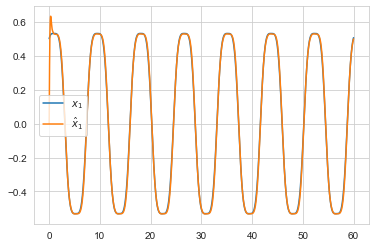

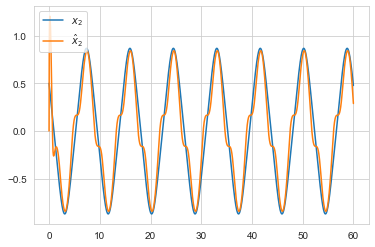

In [16]:
# Plot ground truth and state estimation
import matplotlib.pyplot as plt
for i in range(simulation.shape[1]):
        plt.plot(tq, simulation[:, i, 0], label=rf'$x_{i+1}$')
        plt.plot(tq, estimation[:, i].detach().numpy(),
                 label=rf'$\hat{{x}}_{i+1}$')
        plt.legend()
        plt.show()